13 - 20 Hz 

20- 28 Hz


In [1]:
from EEGModels import EEGNet
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import os
import scipy
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from IPython.display import display, HTML


In [2]:
%run "../trimmer.ipynb"
%run "../training.ipynb"

In [3]:
def bandpass_filter(signal, fs, low_freq, high_freq, order=5):
    # Calculate the normalized cutoff frequencies
    nyquist_freq = 0.5 * fs
    low = low_freq / nyquist_freq
    high = high_freq / nyquist_freq

    # Apply the bandpass filter to each channel separately
    filtered_signal = np.zeros_like(signal)
    for i in range(signal.shape[1]):
        channel_signal = signal[:, i, :]
        b, a = butter(order, [low, high], btype='band')
        filtered_channel = filtfilt(b, a, channel_signal, axis=1)
        filtered_signal[:, i, :] = filtered_channel

    return filtered_signal

# DATA PREPROCESSING AND FILTERING

In [4]:
folder_path = '../../../non_condition/non_condition_data/instruction_data_clean/'
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]

file_list.sort()

print(file_list)

['../../../non_condition/non_condition_data/instruction_data_clean/P_1.mat', '../../../non_condition/non_condition_data/instruction_data_clean/P_10.mat', '../../../non_condition/non_condition_data/instruction_data_clean/P_2.mat', '../../../non_condition/non_condition_data/instruction_data_clean/P_3.mat', '../../../non_condition/non_condition_data/instruction_data_clean/P_4.mat', '../../../non_condition/non_condition_data/instruction_data_clean/P_5.mat', '../../../non_condition/non_condition_data/instruction_data_clean/P_9.mat', '../../../non_condition/non_condition_data/instruction_data_clean/S_1.mat', '../../../non_condition/non_condition_data/instruction_data_clean/S_10.mat', '../../../non_condition/non_condition_data/instruction_data_clean/S_2.mat', '../../../non_condition/non_condition_data/instruction_data_clean/S_3.mat', '../../../non_condition/non_condition_data/instruction_data_clean/S_4.mat', '../../../non_condition/non_condition_data/instruction_data_clean/S_5.mat', '../../..

In [5]:
# X, Y = trim_discontinuous_files(file_list, discontinuous_files, total_found)
X = []
Y = []

for file in file_list:
    x = scipy.io.loadmat(file)
    x = x['data']
    
    # removethe last 250 elements from each trial
    x = x[:,:,:500]

    first_letter = file.split('/')[-1][0]

    # create output vector. If file begins with 'P', then y = [1,0], else y = [0,1], having the same dimension as x
    if first_letter == 'P':
        y = np.zeros((x.shape[0],2))
        y[:,0] = 1
    else:
        y = np.zeros((x.shape[0],2))
        y[:,1] = 1

    X.append(x)
    Y.append(y)


In [6]:
def plot_signals(eeg_array):
    num_samples = eeg_array.shape[0]
    num_channels = eeg_array.shape[1]

    for sample in range(num_samples):
        plt.figure()
        plt.title(f"Sample {sample}")
        for channel in range(num_channels):
            plt.plot(eeg_array[sample, channel, :], label=f"Channel {channel}")
        # plt.legend()
        plt.show()

In [7]:
kick_out = [(3, [23]), (4, [34, 43]), (7, [5, 32]), (12, [22])]

file_dict = {0: 'P_1', 1: 'P_10', 2: 'P_2', 3: 'P_3', 4: 'P_4', 5: 'P_5', 6: 'P_9', 7: 'S_1', 8: 'S_10', 
             9: 'S_2', 10: 'S_3', 11: 'S_4', 12: 'S_5', 13: 'S_9'}

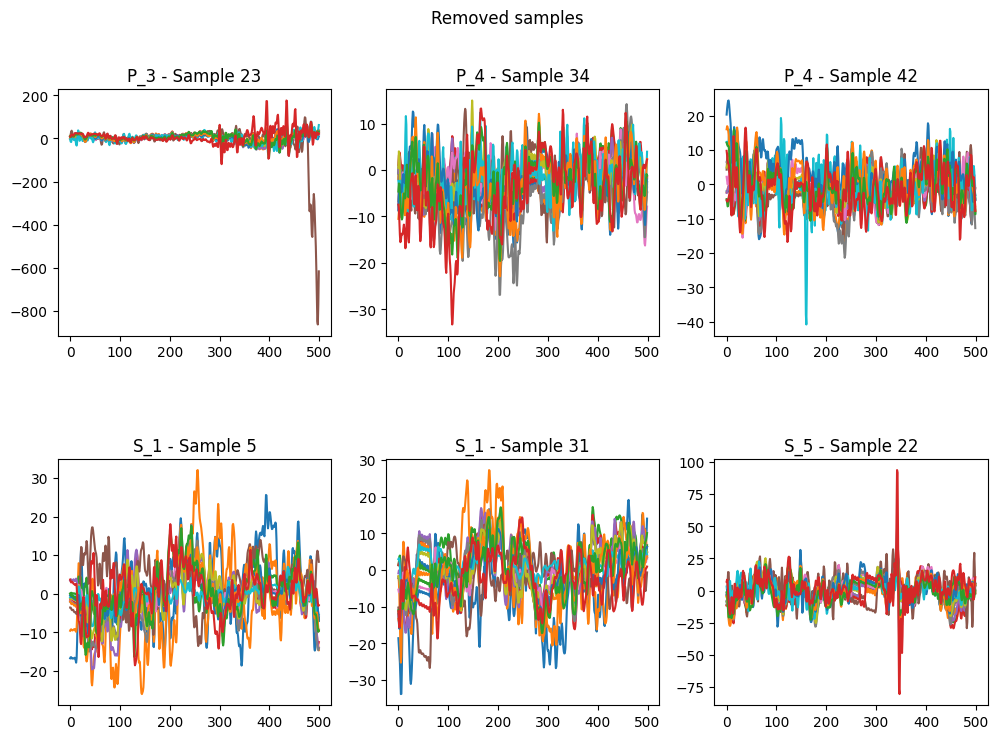

In [8]:
new_X, new_Y = trim_manually(kick_out, X, Y, file_dict)  

In [9]:
print_eliminations(file_list, new_X, new_Y)

(47, 14, 750) -> (47, 14, 500) (47, 2)
(34, 14, 750) -> (34, 14, 500) (34, 2)
(39, 14, 750) -> (39, 14, 500) (39, 2)
(52, 14, 750) -> (51, 14, 500) (51, 2)
(53, 14, 750) -> (51, 14, 500) (51, 2)
(55, 14, 750) -> (55, 14, 500) (55, 2)
(50, 14, 750) -> (50, 14, 500) (50, 2)
(35, 14, 750) -> (33, 14, 500) (33, 2)
(54, 14, 750) -> (54, 14, 500) (54, 2)
(41, 14, 750) -> (41, 14, 500) (41, 2)
(57, 14, 750) -> (57, 14, 500) (57, 2)
(58, 14, 750) -> (58, 14, 500) (58, 2)
(49, 14, 750) -> (48, 14, 500) (48, 2)
(66, 14, 750) -> (66, 14, 500) (66, 2)
Total samples removed:  6
Total samples remaining:  684


# BANDPASS FILTERING

In [10]:
fs = 250

In [11]:
filtered_data_13_20 = []
filtered_data_20_28 = []
for x in new_X:
    filtered_x_13_20 = bandpass_filter(x, fs, 13, 20)
    filtered_x_20_28 = bandpass_filter(x, fs, 20, 28)
    filtered_data_13_20.append(filtered_x_13_20)
    filtered_data_20_28.append(filtered_x_20_28)


Print before and after visualisation of a random eeg signal

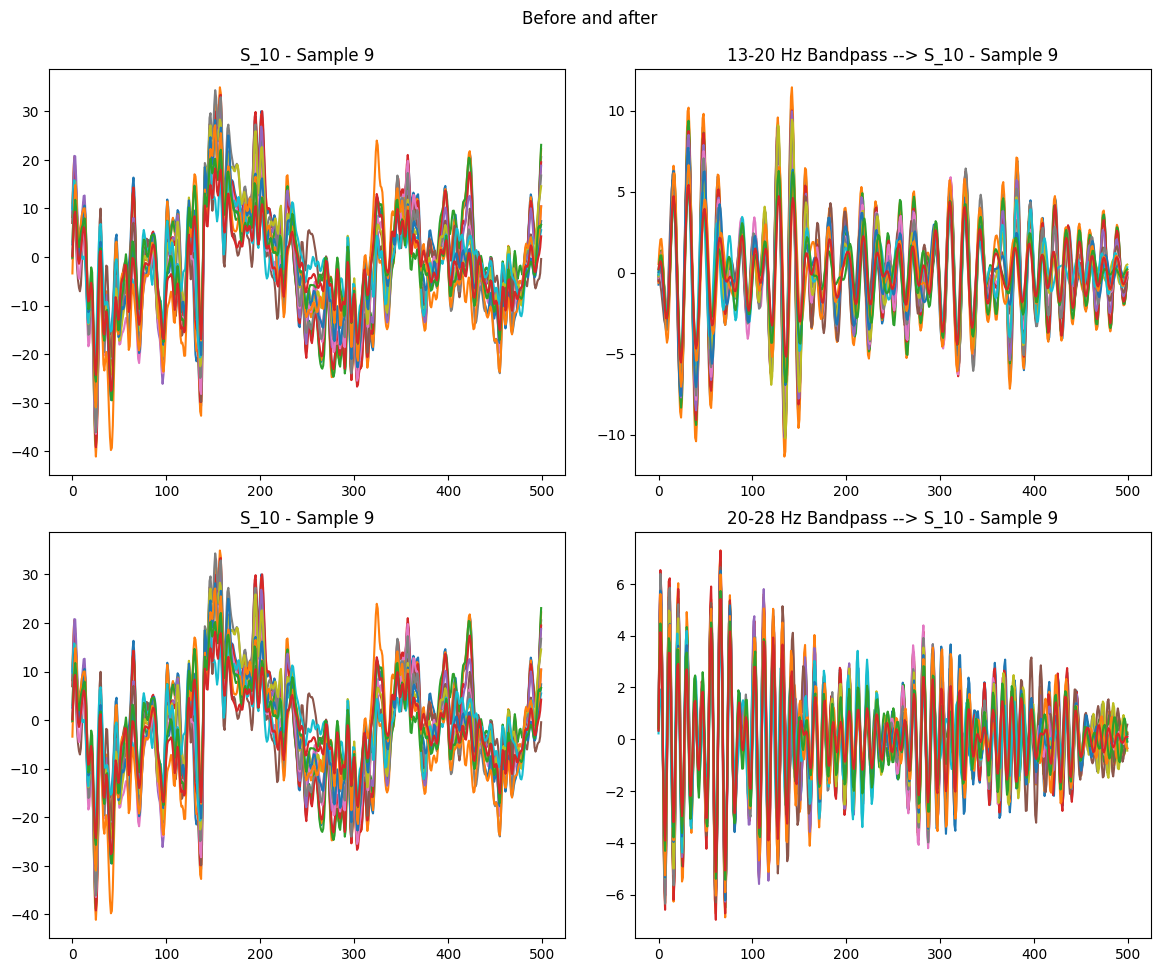

In [12]:
file_index = np.random.randint(0, 13)
sample_index = np.random.randint(0, new_X[file_index].shape[0])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Before and after')
fig.tight_layout(pad=2.0)

plot_sample(new_X[file_index], sample_index, axes[0, 0], file_dict[file_index])
plot_sample(filtered_data_13_20[file_index], sample_index, axes[0, 1], "13-20 Hz Bandpass --> " + file_dict[file_index])
plot_sample(new_X[file_index], sample_index, axes[1, 0], file_dict[file_index])
plot_sample(filtered_data_20_28[file_index], sample_index, axes[1, 1], "20-28 Hz Bandpass --> " + file_dict[file_index])

# TRAINING ON THE FILTERED DATA

In [14]:
scroll_style = """
<style>
.output {
    overflow-y: scroll;
    max-height: 300px; /* Adjust the height as per your preference */
}
</style>
"""

In [15]:
kernels, chans, samples = 1, 14, 500

In [28]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_13_20, new_Y, "../../results/walk_instr_clean/13_20_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../../results/walk_instr_clean/13_20_Hz.txt")

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_13_20, new_Y, "../../results/walk_instr_clean/20_28_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../../results/walk_instr_clean/20_28_Hz.txt")